# Show Effect of Scale on Discovery
Measure the number of stable MOFs discovered as a function of node-hours expended

In [70]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import chain
from pathlib import Path

## Load in results from different scales
We have them in the summaries directory, labeled by number of nodes

In [71]:
summaries = []
for path in chain(
    Path("summaries").glob("*-nodes.csv.gz"),
    Path("summaries").glob("*-nodes_repeat-*.csv.gz"),
):
    count = int(path.name.split("-")[0])
    summaries.append([count, pd.read_csv(path)])
summaries.sort(key=lambda x: x[0])
print(f"Found {len(summaries)} runs:", " ".join(str(x[0]) for x in summaries))

Found 7 runs: 32 32 64 64 128 256 450


# Get the Average Rate for 32-nodes w/o Training
We'll use that as the "no MOFA" baseline

In [72]:
baseline_rate = []
for run in Path("summaries/").glob("64-nodes_no-retrain*.csv.gz"):
    summary = pd.read_csv(run)
    print(summary.columns)
    baseline_rate.append(
        summary["cumulative_found"].iloc[-1] / summary["walltime"].iloc[-1] * 3600
    )
baseline_rate = np.mean(baseline_rate)
print(f"Found a baseline rate of {baseline_rate:.2f} MOFs per hour")

Index(['name', 'topology', 'catenation', 'time', 'gas_storage.CO2',
       'structure_stability.uff', 'ligand.COO.name', 'ligand.COO.smiles',
       'ligand.COO.prompt_atoms', 'ligand.COO.metadata.model_version',
       'ligand.cyano.name', 'ligand.cyano.smiles', 'ligand.cyano.prompt_atoms',
       'ligand.cyano.metadata.model_version', 'model_version',
       'cumulative_found', 'walltime'],
      dtype='object')
Index(['name', 'topology', 'catenation', 'time', 'gas_storage.CO2',
       'structure_stability.uff', 'ligand.COO.name', 'ligand.COO.smiles',
       'ligand.COO.prompt_atoms', 'ligand.COO.metadata.model_version',
       'ligand.cyano.name', 'ligand.cyano.smiles', 'ligand.cyano.prompt_atoms',
       'ligand.cyano.metadata.model_version', 'model_version',
       'cumulative_found', 'walltime'],
      dtype='object')
Found a baseline rate of 274.74 MOFs per hour


In [73]:
baseline_rate

274.7368145771466

## Plot the Efficiency Over Time
Show that we get better at finding MOFs over time

In [74]:
# lowest_slope

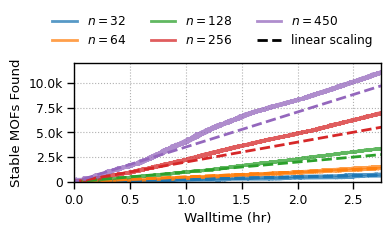

In [75]:
with sns.plotting_context("paper", font_scale=1.0):

    fig, ax = plt.subplots(figsize=(4, 3))
    tmp_colors = {
        32: "tab:blue",
        64: "tab:orange",
        128: "tab:green",
        256: "tab:red",
        450: "tab:purple",
    }

    lowest_slope = np.mean(
        [
            summary["cumulative_found"].iloc[-1] / summary["walltime"].iloc[-1] * 3600
            for count, summary in summaries
            if count == min(tmp_colors.keys())
        ]
    )
    done = set()
    for count, summary in summaries:
        ax.plot(
            summary["walltime"] / 3600,
            summary["cumulative_found"],
            "-",
            color=tmp_colors[count],
            alpha=0.75,
            lw=2,
            label=f"$n={count}$" if count not in done else None,
        )
        done.add(count)

    ax.plot(
        [-100, -90],
        [-1000, -1000],
        color="black",
        linestyle="--",
        label="linear scaling",
        lw=2,
    )

    for count, summary in summaries:
        ax.plot(
            ax.get_xlim(),
            np.multiply(ax.get_xlim(), baseline_rate * count / 35),
            "--",
            lw=2,
            color=tmp_colors[count],
        )

    ax.legend(
        ncols=3,
        loc="upper center",
        bbox_to_anchor=(0.45, 1.5),
        frameon=False,
    )

    ax.set_ylim(0, 12_000)
    ax.set_xlim(0, 2.75)

    ax.set_yticks(
        [0, 2500, 5000, 7500, 10000],
        ["0", "2.5k", "5.0k", "7.5k", "10.0k"],
    )

    ax.set_xlabel("Walltime (hr)")
    ax.set_ylabel("Stable MOFs Found")

    fig.tight_layout()
    handles, labels = ax.get_legend_handles_labels()

    plt.grid(linestyle=":")
    plt.savefig("figures/fig7.pdf")
    plt.show()